In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
plt.style.use('dark_background')
plt.tight_layout()
%matplotlib inline
import os
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline
import imblearn
import shap
import missingno as msno

In [2]:
df= pd.read_csv('star_classification.csv')

In [3]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

In [15]:
df['MJD']

0        56354
1        58158
2        55592
3        58039
4        56187
         ...  
99995    57749
99996    56934
99997    54535
99998    56368
99999    57104
Name: MJD, Length: 100000, dtype: int64

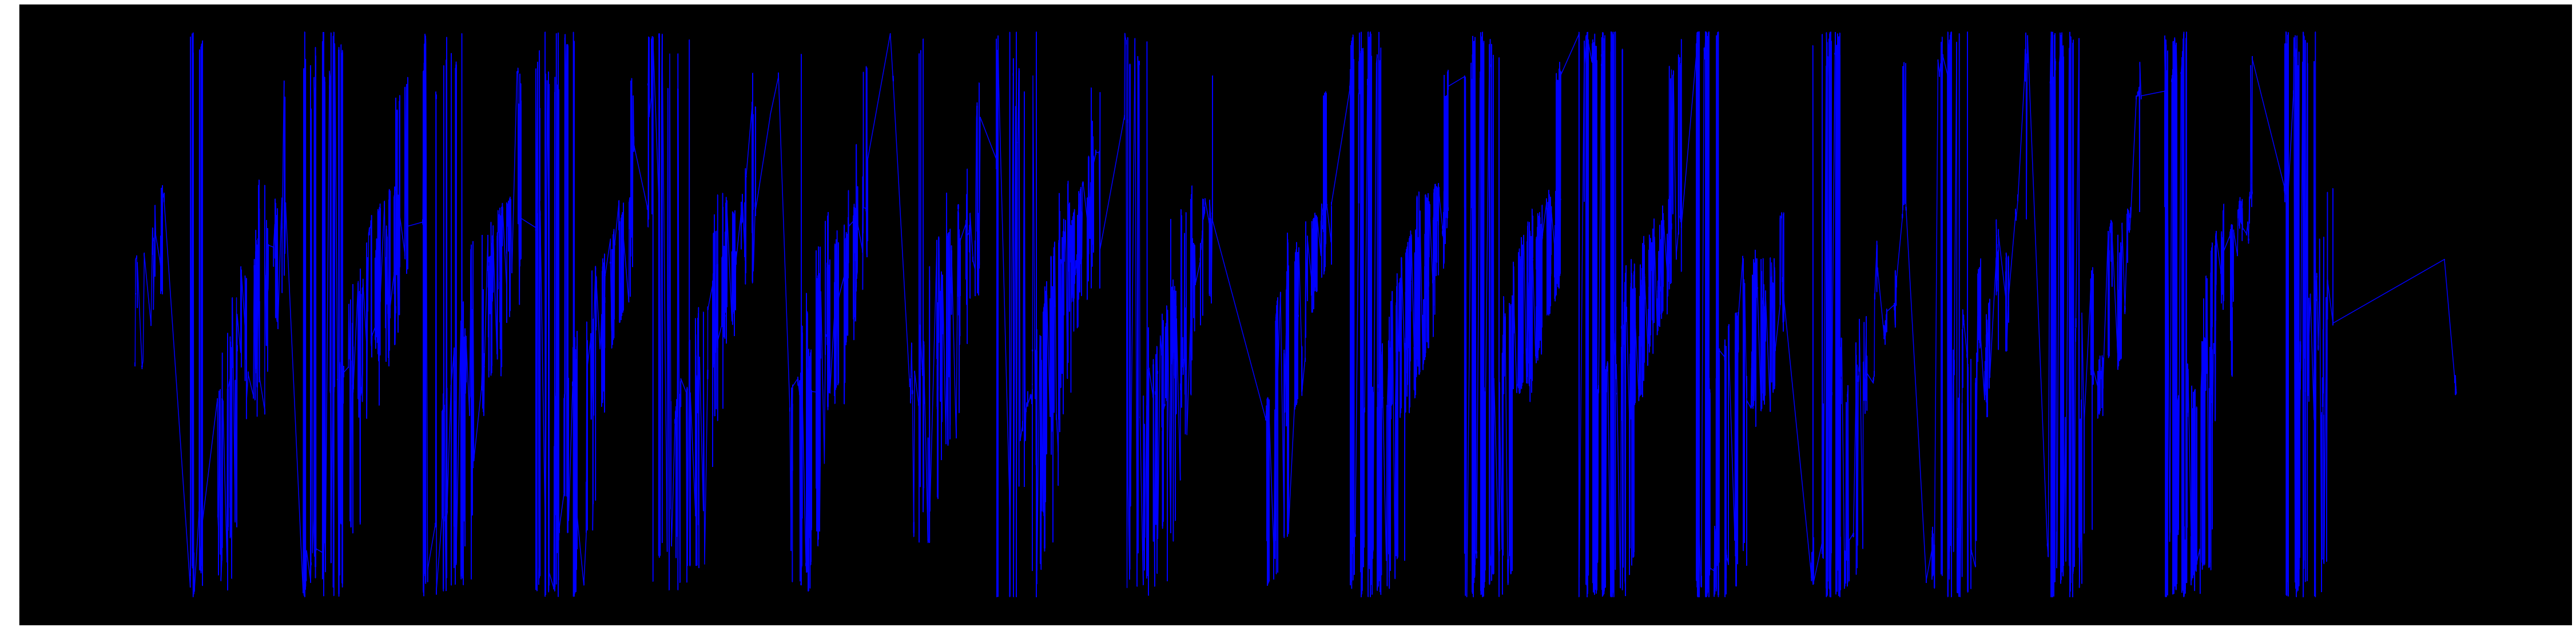

In [14]:
x1= df.sort_values(by= 'MJD', ascending=True)
plt.rcParams['figure.figsize']= (80, 20)
plt.plot(x1['MJD'], x1['alpha'], 'b-')
plt.show();

In [33]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
df['class']= encoder.fit_transform(df['class'])

<AxesSubplot:>

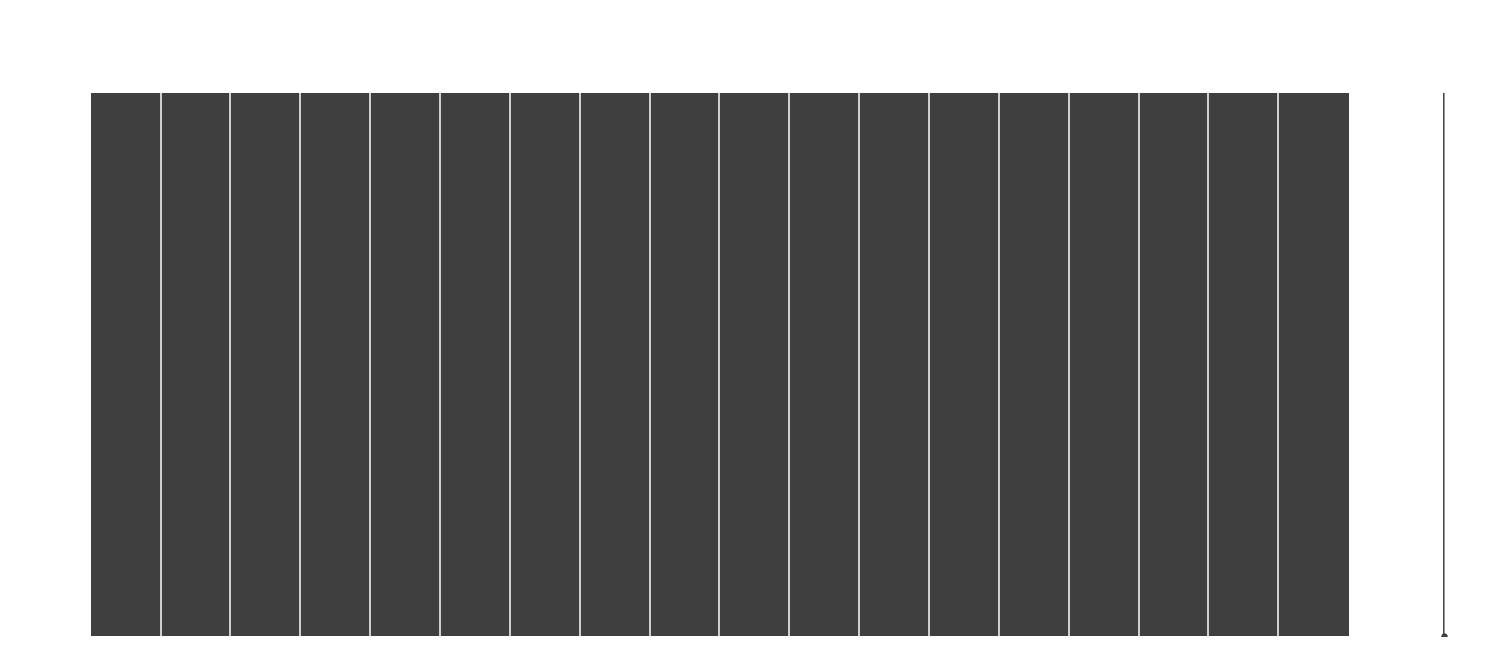

In [21]:
msno.matrix(df)

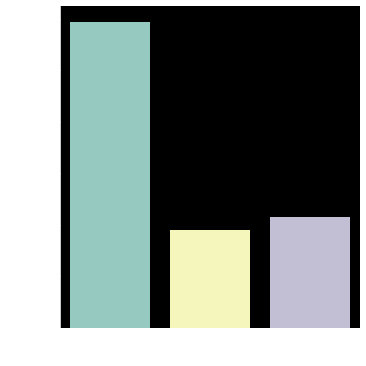

In [13]:
sns.catplot(data= df, x= 'class', kind= 'count', height= 5)
plt.show();

In [34]:
X_tr, x_t, Y_tr, y_t= train_test_split(df.drop(columns= ['class']), df['class'], test_size= 0.2)

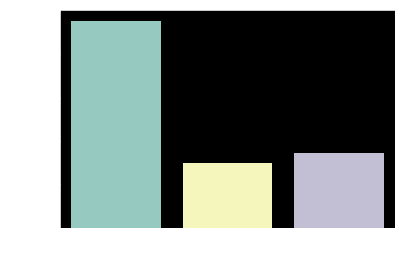

In [37]:
sns.countplot(x= Y_tr)
plt.show();

In [42]:
from imblearn.combine import SMOTETomek
smt= SMOTETomek(n_jobs= -1)
X_tr, Y_tr= smt.fit_resample(X_tr,  Y_tr)

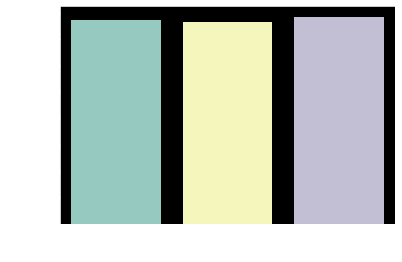

In [43]:
sns.countplot(x= Y_tr)
plt.show();

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
clf_logreg= LogisticRegression()
clf_rf= RandomForestClassifier(n_jobs= -1, verbose= 3)
clf_gb= GradientBoostingClassifier(verbose= 3)
clf_dt= DecisionTreeClassifier()
clf_xgb= XGBClassifier(n_jobs= -1)

In [76]:
from sklearn.pipeline import Pipeline
pipe= Pipeline([('estimator', clf_logreg),])
params= [dict(estimator= [clf_dt, clf_rf, clf_gb, clf_xgb],)]
        
grid= GridSearchCV(pipe, param_grid= params, verbose= 3,
                  n_jobs= -1)
grid.fit(X_tr, Y_tr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:48:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=Pipeline(steps=[('estimator', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'estimator': [DecisionTreeClassifier(),
                                        RandomForestClassifier(n_jobs=-1,
                                                               verbose=3),
                                        GradientBoostingClassifier(verbose=3),
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=Fa...
                                                      interaction_constraints=None,
                                                      learning_rate=No

In [78]:
grid.best_params_

{'estimator': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None,
               enable_categorical=False, gamma=None, gpu_id=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=-1, num_parallel_tree=None,
               predictor=None, random_state=None, reg_alpha=None,
               reg_lambda=None, scale_pos_weight=None, subsample=None,
               tree_method=None, validate_parameters=None, verbosity=None)}

In [83]:
dt_class= DecisionTreeClassifier()
pipe_dt= Pipeline([('classifier', dt_class),])
kf= KFold(n_splits= 10)
results= cross_val_score(dt_class, X_tr, Y_tr, cv= kf)

In [85]:
dt_class.fit(X_tr, Y_tr)
print(accuracy_score(dt_class.predict(X_tr), Y_tr))
print(accuracy_score(dt_class.predict(x_t), y_t))
print(np.mean(results))

1.0
0.96065
0.974489720378744


In [ ]:
params= dict(classfier__max_depth)